# Logistic regression model



## Setup

In [1]:
!git clone --depth 1 https://github.com/probml/pyprobml /pyprobml &> /dev/null
%cd -q /pyprobml/scripts

In [2]:
!pip install -q optax
!pip install -q blackjax
!pip install -q sgmcmcjax

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import itertools
import warnings
from functools import partial

import jax
import jax.numpy as jnp
from jax.random import uniform, normal, bernoulli, split
from jax import jit, grad, value_and_grad, vmap
from jax.experimental import optimizers
from jax.scipy.special import logsumexp

from blackjax import nuts, stan_warmup
import optax

import sgmcmc_subspace_lib as sub
from sgmcmc_utils import build_optax_optimizer, build_nuts_sampler
from sgmcmcjax.samplers import *

## Generate Data

This part is based on https://github.com/jeremiecoullon/SGMCMCJax/blob/master/docs/nbs/models/logistic_regression.py

In [4]:
# ignore by GPU/TPU message (generated by jax module)
warnings.filterwarnings("ignore", message="No GPU/TPU found, falling back to CPU.")


# Sample initial beta values from random normal
def init_params(rng_key, d):
    return normal(rng_key, (d,))


def gen_cov_mat(key, d, rho):
    Sigma0 = np.diag(np.ones(d))
    for i in range(1, d):
        for j in range(0, i):
            Sigma0[i, j] = (uniform(key) * 2 * rho - rho) ** (i - j)
            Sigma0[j, i] = Sigma0[i, j]

    return jnp.array(Sigma0)


def logistic(theta, x):
    return 1 / (1 + jnp.exp(-jnp.dot(theta, x)))


def gen_data(key, dim, N):
    """
    Generate data with dimension `dim` and `N` data points
    Parameters
    ----------
    key: uint32
        random key
    dim: int
        dimension of data
    N: int
        Size of dataset
    Returns
    -------
    theta_true: ndarray
        Theta array used to generate data
    X: ndarray
        Input data, shape=(N,dim)
    y: ndarray
        Output data: 0 or 1s. shape=(N,)
    """
    key, theta_key, cov_key, x_key = split(key, 4)
    rho = 0.4
    print(f"Generating data, with N={N} and dim={dim}")
    theta_true = normal(theta_key, shape=(dim,)) * jnp.sqrt(10)
    covX = gen_cov_mat(cov_key, dim, rho)
    X = jnp.dot(normal(x_key, shape=(N, dim)), jnp.linalg.cholesky(covX))

    p_array = batch_logistic(theta_true, X)
    keys = split(key, N)
    y = batch_benoulli(keys, p_array).astype(jnp.int32)
    return theta_true, X, y

In [5]:
@jit
def predict(params, inputs):
    return batch_logistic(params, inputs) > 0.5


@jit
def accuracy(params, batch):
    inputs, targets = batch
    predicted_class = predict(params, inputs)
    return jnp.mean(predicted_class == targets)


@jit
def loglikelihood(theta, x_val, y_val):
    return -logsumexp(jnp.array([0.0, (1.0 - 2.0 * y_val) * jnp.dot(theta, x_val)]))


@jit
def logprior(theta):
    return -(0.5 / 10) * jnp.dot(theta, theta)

In [6]:
batch_logistic = jit(vmap(logistic, in_axes=(None, 0)))
batch_benoulli = vmap(bernoulli, in_axes=(0, 0))
batch_loglikelihood = vmap(loglikelihood, in_axes=(None, 0, 0))

In [7]:
dim = 10  # Choose a dimension for the parameters (10, 50,100 in the paper)
subspace_dim = 2  # Choose a dimension for the subspace parameters
ndata = 10000  # Number of data points
nwarmup = 1000  # Number of iterations during warmup phase
nsamples = 10000  # Number of SGMCMC iterations
nsamplesCV = nsamples // 2
key = jax.random.PRNGKey(42)

In [8]:
theta_true, X, y = gen_data(key, dim, ndata)
batch_size = int(0.01 * X.shape[0])
data = (X, y)

init_key, key = split(key)
theta_init = init_params(init_key, dim)

Generating data, with N=10000 and dim=10


## SGD

In [9]:
niters = 5000

learning_rate = 6e-5
opt = optax.sgd(learning_rate=learning_rate)
optimizer = build_optax_optimizer(opt, loglikelihood, logprior, data, batch_size, pbar=False)

opt_key, key = split(key)
sgd_params, logpost_array = optimizer(opt_key, niters, theta_init)

In [10]:
train_accuracy = accuracy(sgd_params, data)
print("Training set accuracy {}".format(train_accuracy))

Training set accuracy 0.9376999735832214


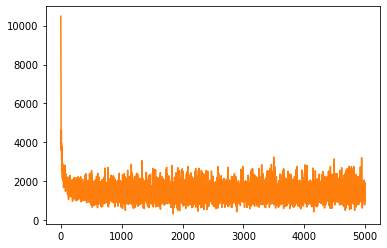

In [11]:
plt.plot(-logpost_array, color="tab:orange")
plt.show()

### Subspace Model

In [12]:
sub_opt_key, key = split(key)
sgd_sub_params, _, opt_log_post_trace, _ = sub.subspace_optimizer(
    sub_opt_key, loglikelihood, logprior, theta_init, data, batch_size, subspace_dim, nwarmup, nsamples, opt, pbar=False
)

In [13]:
train_accuracy = accuracy(sgd_sub_params, data)
print("Training set accuracy {}".format(train_accuracy))

Training set accuracy 0.9388999938964844


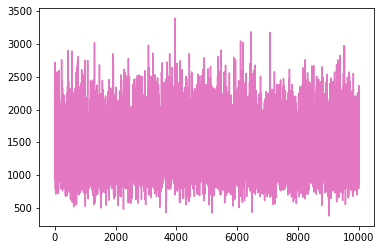

In [14]:
plt.plot(-opt_log_post_trace, color="tab:pink")
plt.show()

## NUTS

In [15]:
nuts_sampler = build_nuts_sampler(nwarmup, loglikelihood, logprior, data, batch_size=ndata, pbar=False)
nuts_key, key = split(key)
nuts_params = nuts_sampler(nuts_key, nsamples // 10, theta_init)

In [16]:
train_accuracy = accuracy(jnp.mean(nuts_params, axis=0), data)
print("Training set accuracy {}".format(train_accuracy))

Training set accuracy 0.9384999871253967


### Subspace Model

In [17]:
build_nuts_sampler_partial = partial(build_nuts_sampler, nwarmup=nwarmup)
nuts_key, key = split(key)
nuts_sub_params = sub.subspace_sampler(
    nuts_key,
    loglikelihood,
    logprior,
    theta_init,
    build_nuts_sampler_partial,
    data,
    batch_size,
    subspace_dim,
    nsamples,
    nsteps_full=0,
    nsteps_sub=0,
    use_cv=False,
    opt=None,
    pbar=False,
)

## SGLD

In [18]:
dt = 1e-5

In [19]:
# Run sampler
sgld_sampler = build_sgld_sampler(dt, loglikelihood, logprior, data, batch_size)
sgld_key, key = split(key)
sgld_output = sgld_sampler(sgld_key, nsamples, theta_init)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Subspace Sampler

In [20]:
build_sgld_sampler_partial = partial(build_sgld_sampler, dt=dt)
sgld_key, key = split(key)
sgld_sub_output = sub.subspace_sampler(
    sgld_key,
    loglikelihood,
    logprior,
    theta_init,
    build_sgld_sampler_partial,
    data,
    batch_size,
    subspace_dim,
    nsamples,
    nsteps_full=0,
    nsteps_sub=0,
    use_cv=False,
    opt=None,
    pbar=False,
)

## SGLDCV

In [21]:
dt = 1e-5

In [22]:
sgldCV_sampler = build_sgldCV_sampler(dt, loglikelihood, logprior, data, batch_size, sgd_params)
sgldCV_key, key = split(key)
sgldCV_output = sgldCV_sampler(sgldCV_key, nsamplesCV, sgd_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Subspace Sampler

In [23]:
build_sgldCV_sampler_partial = partial(build_sgldCV_sampler, dt=dt)
sgldCV_key, key = split(key)
sgldCV_sub_output = sub.subspace_sampler(
    sgldCV_key,
    loglikelihood,
    logprior,
    theta_init,
    build_sgldCV_sampler_partial,
    data,
    batch_size,
    subspace_dim,
    nsamples,
    nsteps_full=niters // 2,
    nsteps_sub=niters // 2,
    use_cv=True,
    opt=opt,
    pbar=False,
)

## SGHMC

In [24]:
L = 5
dt = 1e-6

In [25]:
sghmc_sampler = build_sghmc_sampler(dt, L, loglikelihood, logprior, data, batch_size)
sghmc_key, key = split(key)
sghmc_output = sghmc_sampler(sghmc_key, nsamples, theta_init)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Subspace Sampler

In [26]:
build_sghmc_sampler_partial = partial(build_sghmc_sampler, dt=dt, L=L)
sghmc_key, key = split(key)
sghmc_sub_output = sub.subspace_sampler(
    sghmc_key,
    loglikelihood,
    logprior,
    theta_init,
    build_sghmc_sampler_partial,
    data,
    batch_size,
    subspace_dim,
    nsamples,
    nsteps_full=0,
    nsteps_sub=0,
    use_cv=False,
    opt=None,
    pbar=False,
)

## SGHMCCV

In [27]:
dt = 1e-7  # step size parameter
L = 5

In [28]:
sghmcCV_sampler = build_sghmcCV_sampler(dt, L, loglikelihood, logprior, data, batch_size, sgd_params)
sghmcCV_key, key = split(key)
sghmcCV_output = sghmcCV_sampler(sghmcCV_key, nsamplesCV, sgd_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Subspace Sampler

In [29]:
build_sghmcCV_sampler_partial = partial(build_sghmcCV_sampler, dt=dt, L=L)
sghmcCV_key, key = split(key)
sghmcCV_sub_output = sub.subspace_sampler(
    sghmcCV_key,
    loglikelihood,
    logprior,
    theta_init,
    build_sghmcCV_sampler_partial,
    data,
    batch_size,
    subspace_dim,
    nsamples,
    nsteps_full=niters // 2,
    nsteps_sub=niters // 2,
    use_cv=True,
    opt=opt,
    pbar=False,
)

## SGNHT


In [30]:
dt = 1e-6  # step size parameter
a = 0.02

In [31]:
sgnht_sampler = build_sgnht_sampler(dt, loglikelihood, logprior, data, batch_size, a=a)
sgnht_key, key = split(key)
sgnht_output = sgnht_sampler(sgnht_key, nsamples, theta_init)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Subspace Sampler

In [32]:
build_sgnht_sampler_partial = partial(build_sgnht_sampler, dt=dt, a=a)
sgnht_key, key = split(key)
sgnht_sub_output = sub.subspace_sampler(
    sgnht_key,
    loglikelihood,
    logprior,
    theta_init,
    build_sgnht_sampler_partial,
    data,
    batch_size,
    subspace_dim,
    nsamples,
    nsteps_full=0,
    nsteps_sub=0,
    use_cv=False,
    opt=opt,
    pbar=False,
)

## SGHNTCV

In [33]:
dt = 1e-6  # step size parameter
a = 0.02

In [34]:
sgnhtCV_sampler = build_sgnhtCV_sampler(dt, loglikelihood, logprior, data, batch_size, sgd_params, a=a)
sgnhtCV_key, key = split(key)
sgnhtCV_output = sgnhtCV_sampler(sgnhtCV_key, nsamplesCV, sgd_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Subspace Sampler

In [35]:
build_sgnhtCV_sampler_partial = partial(build_sgnhtCV_sampler, dt=dt, a=a)
sgnhtCV_key, key = split(key)
sgnhtCV_sub_output = sub.subspace_sampler(
    sgnhtCV_key,
    loglikelihood,
    logprior,
    theta_init,
    build_sgnhtCV_sampler_partial,
    data,
    batch_size,
    subspace_dim,
    nsamples,
    nsteps_full=niters // 2,
    nsteps_sub=niters // 2,
    use_cv=True,
    opt=opt,
    pbar=False,
)

## ULA - SGLD with the full dataset

In [36]:
dt = 4e-5  # step size parameter

In [37]:
ula_sampler = build_sgld_sampler(dt, loglikelihood, logprior, data, batch_size=ndata)
ula_key, key = split(key)
ula_output = ula_sampler(ula_key, nsamples, theta_init)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Subspace Sampler

In [38]:
build_sgld_sampler_partial = partial(build_sgld_sampler, dt=dt)
ula_key, key = split(key)
ula_sub_output = sub.subspace_sampler(
    ula_key,
    loglikelihood,
    logprior,
    theta_init,
    build_sgld_sampler_partial,
    data,
    ndata,
    subspace_dim,
    nsamples,
    nsteps_full=0,
    nsteps_sub=0,
    use_cv=False,
    opt=None,
    pbar=False,
)

## Trace plots

In [39]:
def trace_plot(outs):
    nrows, ncols = 2, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

    for ax, (title, out) in zip(axes.flatten(), outs.items()):
        ax.plot(out)
        ax.set_title(title)
        ax.set_xlabel("Iteration")
        ax.grid(color="white", linestyle="-", linewidth=2)
        ax.set_axisbelow(True)
        ax.set_facecolor("#EAEBF0")

    plt.tight_layout()
    plt.savefig("traceplot.pdf", dpi=300)
    plt.show()

In [40]:
outs = {
    "STAN": nuts_params,
    "SGLD": sgld_output,
    "SGLDCV": sgldCV_output,
    "ULA": ula_output,
    "SGHMC": sghmc_output,
    "SGHMCCV": sghmcCV_output,
    "SGNHT": sgnht_output,
    "SGNHTCV": sgnhtCV_output,
}

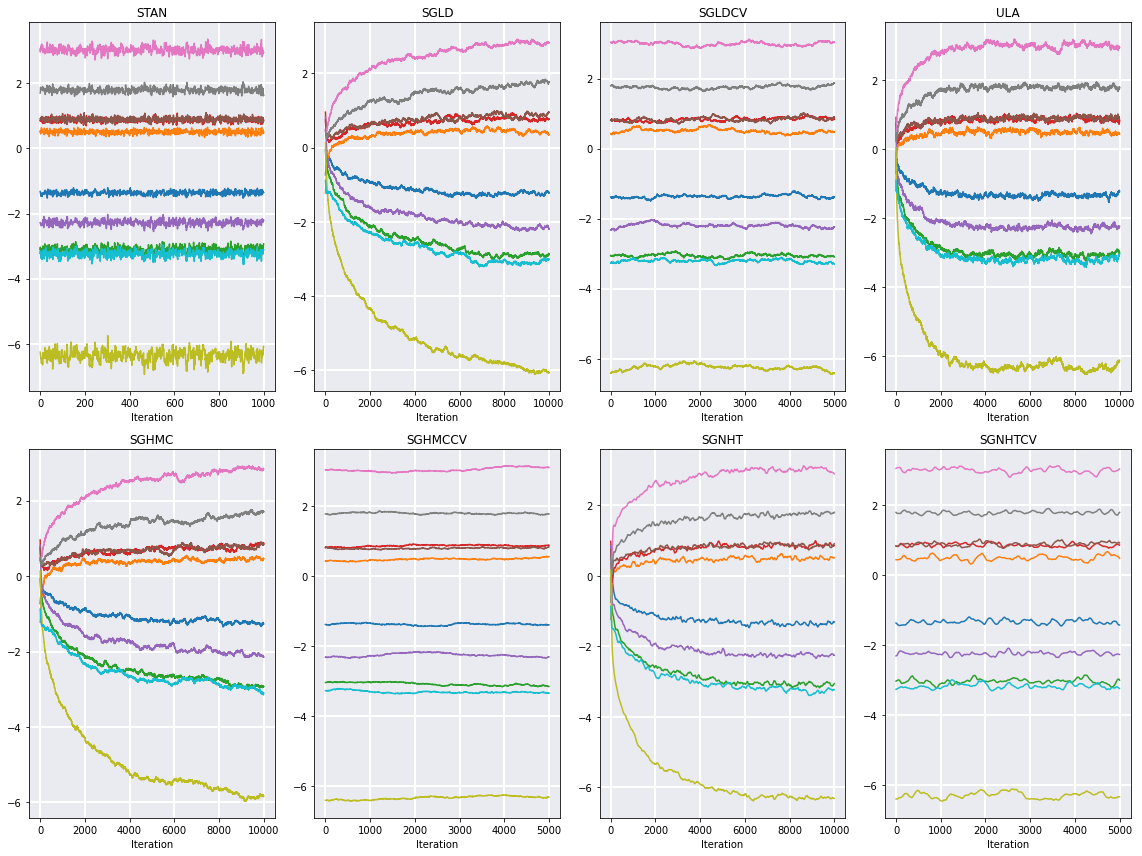

In [41]:
trace_plot(outs)

In [42]:
subspace_outs = {
    "STAN": nuts_sub_params,
    "SGLD": sgld_sub_output,
    "SGLDCV": sgldCV_sub_output,
    "ULA": ula_sub_output,
    "SGHMC": sghmc_sub_output,
    "SGHMCCV": sghmcCV_sub_output,
    "SGNHT": sgnht_sub_output,
    "SGNHTCV": sgnhtCV_sub_output,
}

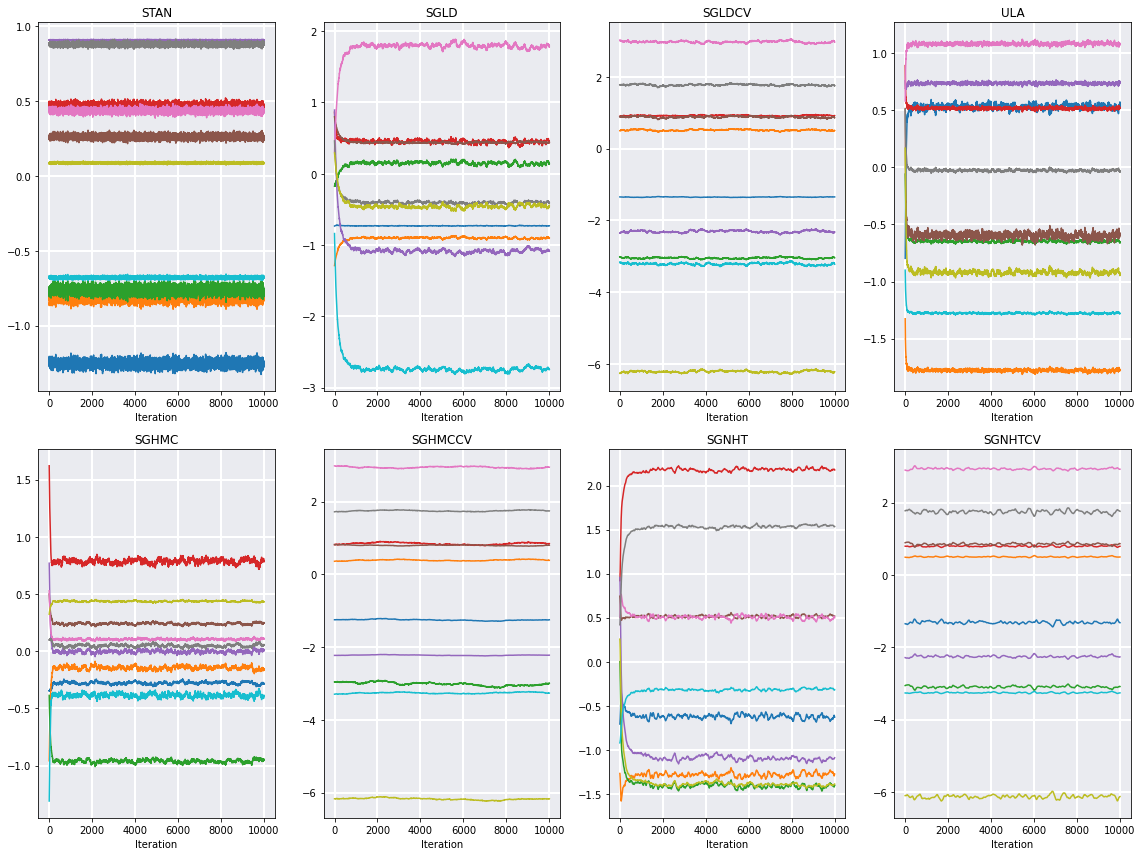

In [43]:
trace_plot(subspace_outs)